# Solar Transformer

In [ ]:
%pip install wandb scikit-learn tensorflow_probability tensorflow_addons matplotlib

In [117]:
from tensorflow.keras.layers import Add, Dense, Dropout, Layer, LayerNormalization, MultiHeadAttention, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow_addons.metrics import RSquare
from wandb.keras import WandbCallback

import os
import math
import wandb
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

FILL_VALUE = -999.0

In [118]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.63.167.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.63.167.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Addons

In [120]:
def timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    drop_remainder=True,
    many_to_many=False,
    start_index=None,
    end_index=None):
  """Creates a dataset of sliding windows over a timeseries provided as array.

  This function takes in a sequence of data-points gathered at
  equal intervals, along with time series parameters such as
  length of the sequences/windows, spacing between two sequence/windows, etc.,
  to produce batches of timeseries inputs and targets.

  Args:
    data: Numpy array or eager tensor
      containing consecutive data points (timesteps).
      Axis 0 is expected to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
      Pass None if you don't have target data (in this case the dataset will
      only yield the input data).
    sequence_length: Length of the output sequences (in number of timesteps).
    sequence_stride: Period between successive output sequences.
      For stride `s`, output samples would
      start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
    sampling_rate: Period between successive individual timesteps
      within sequences. For rate `r`, timesteps
      `data[i], data[i + r], ... data[i + sequence_length]`
      are used for creating a sample sequence.
    batch_size: Number of timeseries samples in each batch
      (except maybe the last one). If `None`, the data will not be batched
      (the dataset will yield individual samples).
    shuffle: Whether to shuffle output samples,
      or instead draw them in chronological order.
    seed: Optional int; random seed for shuffling.
    drop_remainder: Optional bool; representing whether the last windows 
      should be dropped if their size is smaller than size.
    many_to_many: Optional bool; whether the target
      corresponding to the window that starts at index `i` or 
      for each timestep of window
      (see example 2 and 3 below).
    start_index: Optional int; data points earlier (exclusive)
      than `start_index` will not be used
      in the output sequences. This is useful to reserve part of the
      data for test or validation.
    end_index: Optional int; data points later (exclusive) than `end_index`
      will not be used in the output sequences.
      This is useful to reserve part of the data for test or validation.

  Returns:
    A tf.data.Dataset instance. If `targets` was passed, the dataset yields
    tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
    only `batch_of_sequences`.

  Example 1:

  Consider indices `[0, 1, ... 99]`.
  With `sequence_length=10,  sampling_rate=2, sequence_stride=3`,
  `shuffle=False`, the dataset will yield batches of sequences
  composed of the following indices:

  ```
  First sequence:  [0  2  4  6  8 10 12 14 16 18]
  Second sequence: [3  5  7  9 11 13 15 17 19 21]
  Third sequence:  [6  8 10 12 14 16 18 20 22 24]
  ...
  Last sequence:   [78 80 82 84 86 88 90 92 94 96]
  ```

  In this case the last 3 data points are discarded since no full sequence
  can be generated to include them (the next sequence would have started
  at index 81, and thus its last step would have gone over 99).

  Example 2: Temporal regression.

  Consider an array `data` of scalar values, of shape `(steps,)`.
  To generate a dataset that uses the past 10
  timesteps to predict the next timestep, you would use:

  ```python
  input_data = data[:-10]
  targets = data[10:]
  dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
      input_data, targets, sequence_length=10)
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
    break
  ```

  Example 3: Temporal regression for many-to-many architectures.

  Consider two arrays of scalar values `X` and `Y`,
  both of shape `(100,)`. The resulting dataset should consist samples with
  20 timestamps each. The samples should not overlap.
  To generate a dataset that uses the current timestamp
  to predict the corresponding target timestep, you would use:

  Option 1:

  ```python
  X = np.arange(100)
  Y = X*2

  sample_length = 20
  input_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X, None, sequence_length=sample_length, sequence_stride=sample_length)
  target_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    Y, None, sequence_length=sample_length, sequence_stride=sample_length)

  for batch in zip(input_dataset, target_dataset):
    inputs, targets = batch
    assert np.array_equal(inputs[0], X[:sample_length])

    # second sample equals output timestamps 20-40
    assert np.array_equal(targets[1], Y[sample_length:2*sample_length])
    break
  ```

  Option 2:

  ```python
  X = np.arange(100)
  Y = X*2

  sample_length = 20
  dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X, Y, sequence_length=sample_length, sequence_stride=sample_length, many_to_many=True)

  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], X[:sample_length])

    # second sample equals output timestamps 20-40
    assert np.array_equal(targets[1], Y[sample_length:2*sample_length])
    break
  ```
  """
  if start_index:
    if start_index < 0:
      raise ValueError(f'`start_index` must be 0 or greater. Received: '
                       f'start_index={start_index}')
    if start_index >= len(data):
      raise ValueError(f'`start_index` must be lower than the length of the '
                       f'data. Received: start_index={start_index}, for data '
                       f'of length {len(data)}')
  if end_index:
    if start_index and end_index <= start_index:
      raise ValueError(f'`end_index` must be higher than `start_index`. '
                       f'Received: start_index={start_index}, and '
                       f'end_index={end_index} ')
    if end_index >= len(data):
      raise ValueError(f'`end_index` must be lower than the length of the '
                       f'data. Received: end_index={end_index}, for data of '
                       f'length {len(data)}')
    if end_index <= 0:
      raise ValueError('`end_index` must be higher than 0. '
                       f'Received: end_index={end_index}')

  # Validate strides
  if sampling_rate <= 0:
    raise ValueError(f'`sampling_rate` must be higher than 0. Received: '
                     f'sampling_rate={sampling_rate}')
  if sampling_rate >= len(data):
    raise ValueError(f'`sampling_rate` must be lower than the length of the '
                     f'data. Received: sampling_rate={sampling_rate}, for data '
                     f'of length {len(data)}')
  if sequence_stride <= 0:
    raise ValueError(f'`sequence_stride` must be higher than 0. Received: '
                     f'sequence_stride={sequence_stride}')
  if sequence_stride >= len(data):
    raise ValueError(f'`sequence_stride` must be lower than the length of the '
                     f'data. Received: sequence_stride={sequence_stride}, for '
                     f'data of length {len(data)}')

  if start_index is None:
    start_index = 0
  if end_index is None:
    end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory usage).
  num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
  if targets is not None:
    num_seqs = min(num_seqs, len(targets))

  dataset = tf.data.Dataset.from_tensor_slices(data[start_index : end_index])
  dataset = dataset.window(sequence_length, shift=sequence_stride, stride=sampling_rate, drop_remainder=drop_remainder)
  dataset = dataset.flat_map(lambda x: x.batch(sequence_length, drop_remainder=drop_remainder))

  if targets is not None:
    if many_to_many:
      target_ds = tf.data.Dataset.from_tensor_slices(targets[start_index : end_index])
      target_ds = target_ds.window(sequence_length, shift=sequence_stride, stride=sampling_rate, drop_remainder=drop_remainder)
      target_ds = target_ds.flat_map(lambda x: x.batch(sequence_length, drop_remainder=drop_remainder))
    else:
      target_ds = tf.data.Dataset.from_tensors(targets[start_index : end_index])
      target_ds = tf.data.Dataset.zip((target_ds.repeat(), tf.data.Dataset.range(0, num_seqs, sequence_stride))).map(
        lambda steps, i: tf.gather(steps, i),
        num_parallel_calls=tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((dataset, target_ds))
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  if batch_size is not None:
    if shuffle:
      # Shuffle locally at each iteration
      dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
  else:
    if shuffle:
      dataset = dataset.shuffle(buffer_size=1024, seed=seed)
  return dataset

## Plotting

In [121]:
def plot_4d(matrix):
    fig = plt.figure(figsize=(10, 20), dpi=300)
    plt.title("Attention heatmap")

    # create grid
    x = np.arange(0, matrix.shape[0], 1, dtype=np.int32)  # timesteps
    y = np.arange(0, matrix.shape[1], 1, dtype=np.int32)    # patches
    z = np.arange(0, matrix.shape[2], 1, dtype=np.int32)  # timesteps
    X, Y, Z = np.meshgrid(x, y, z)

    X = X.transpose([1, 0, 2])
    Y = Y.transpose([1, 0, 2])
    Z = Z.transpose([1, 0, 2])

    for I in range(matrix.shape[3]):
        # Plot
        ax = plt.subplot(5, 5, I+1, projection="3d")
        ax.scatter3D(X, Y, Z, c=matrix[:, :, :, I], marker='s', s=99, cmap='magma')
        ax.set_title(
            f"{I}-th patch"
        )
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Patch")
        ax.set_zlabel("Timestep")

    plt.show()

## Init logger

In [122]:
wandb.login()

sweep_config = {
  'method': 'random',
  'metric': {
    'goal': 'minimize',
    'name': 'val_mean_squared_error_daily'
  },
  'parameters': {
      'epochs': {
        'values': [50, 100, 150, 200, 300]
      },
      'num_encoder_layers': {
        'value': 1
      },
      'num_decoder_layers': {
        'value': 1
      },
      'embed_layer_size': {
        'values': [8, 16, 32, 64, 128]
      },
      'fc_layer_size': {
        'values': [8, 16, 32, 64, 128]
      },
      'num_heads': {
        'values': [2, 4, 6]
      },
      'dropout': {
        'values': [0.0, 0.1, 0.15]
      },
      'attention_dropout': {
        'values': [0.0, 0.1, 0.15]
      },
      'optimizer': {
        'value': 'adam'
      },
      'global_clipnorm': {
        'values': [1.0, 2.0, 3.0, 4.0]
      },
      'amsgrad': {
        'value': False
      },
      'learning_rate': {
        'values': [6e-3, 5e-3, 4e-3, 3e-3, 2e-3, 1e-3]
      },
      #'weight_decay': {
      #    'values': [2.5e-4, 1e-4, 5e-5, 1e-5]
      #},
      'warmup_steps': {
        'values': [5, 10, 15, 20, 30]
      },
      'window_size': {
        'values': [7, 14, 21, 28, 35, 42, 49, 56]           # from 1 week to 2 months
      },
      'batch_size': {
        'values': [8, 16, 24, 32]
      },
    }
}


sweep_id = wandb.sweep(sweep_config, project="solar-transformer")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: hpuqsocp
Sweep URL: https://wandb.ai/markub/solar-transformer/sweeps/hpuqsocp


## Masking

In [123]:
# (Timestep, Patch)
def create_look_ahead_mask(size):
  n = tf.cast((size * (size+1) / 2), dtype=tf.int32)
  mask = tfp.math.fill_triangular(tf.ones((n,), dtype=tf.bool), upper=False)
  mask = mask[:, tf.newaxis, :, tf.newaxis]  # (timestep, 1, timestep, 1)
  return mask

## Layer

In [124]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        print(input_shape)
        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], input_shape[2], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        seq_len = tf.shape(inputs)[1]

        x = self.projection(inputs)
        x = x + self.position[:, :seq_len, :, :]

        return self.dropout(x, training=training)

In [125]:
class Encoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        # MultiHeadAttention
        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),       # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training, attention_mask):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha(
            query=x,
            key=x,
            value=x,
            training=training,
            attention_mask=attention_mask,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y])

In [126]:
class Decoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Decoder, self).__init__(**kwargs)

        # MultiHeadAttention
        self.mha_0 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )
        self.mha_1 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)
        self.dropout_2 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)
        self.norm_2 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()
        self.add_2 = Add()

    def call(self, inputs, enc_output, training, look_ahead_mask, attention_mask):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha_0(
            query=x,
            key=x,
            value=x,
            training=training,
            attention_mask=look_ahead_mask,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # Attention block
        y = self.norm_1(x)
        y = self.mha_1(
            query=y,
            key=enc_output,
            value=enc_output,
            training=training,
            attention_mask=attention_mask,
        )
        y = self.dropout_1(y, training=training)
        y = self.add_1([x, y])

        # MLP block
        z = self.norm_2(y)
        z = self.dense_0(z)
        z = self.dense_1(z)
        z = self.dropout_2(z, training=training)

        return self.add_2([y, z])

## Model

In [127]:
class Transformer(Model):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_outputs,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm_enc = Normalization()
        self.input_norm_dec_1 = Normalization()
        self.input_norm_dec_2 = Normalization()

        # Input
        self.pos_embs_0 = PositionalEmbedding(embed_dim, dropout_rate)
        self.pos_embs_1 = PositionalEmbedding(embed_dim, dropout_rate)
        self.pos_embs_2 = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder - daily
        self.enc_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_encoder_layers)
        ]
        self.norm_0 = LayerNormalization(epsilon=1e-5)

        # Decoder - daily
        self.dec_layers_1 = [
            Decoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_decoder_layers)
        ]
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        # Decoder - hourly
        self.dec_layers_2 = [
            Decoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_decoder_layers)
        ]
        self.norm_2 = LayerNormalization(epsilon=1e-5)

        # Output - daily
        self.final_layer_daily = Dense(num_outputs, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_daily_sin = Dense(1, activation=tf.math.sin, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_daily_cos = Dense(1, activation=tf.math.cos, kernel_initializer=TruncatedNormal(stddev=0.02))

        # Output - hourly
        self.final_layer_hourly = Dense(num_outputs, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_hourly_sin = Dense(2, activation=tf.math.sin, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_hourly_cos = Dense(2, activation=tf.math.cos, kernel_initializer=TruncatedNormal(stddev=0.02))

    def call(self, inputs, training):
        inputs, targets_daily, targets_hourly = inputs
        look_ahead_mask_daily, look_ahead_mask_hourly = self.create_masks(targets_daily, targets_hourly)

        #a = tf.gather(inputs, tf.where(tf.reduce_all(tf.math.not_equal(inputs[:, :, :, :-2], FILL_VALUE))[0])
        #b = tf.gather(targets_daily, tf.where(tf.reduce_all(tf.math.not_equal(targets_daily[:, :, :, :-2], FILL_VALUE), axis=-1))[0])
        #c = tf.gather(targets_hourly, tf.where(tf.reduce_all(tf.math.not_equal(targets_hourly[:, :, :, :-4], FILL_VALUE), axis=-1))[0])
        #print(a, b, c)

        # 1. Ak Encoder alebo (Target_daily aj Target_hourly) ma neplatny priklad v batch
        if tf.reduce_all(tf.math.not_equal(inputs, FILL_VALUE)):   # Ked FALSE tak priklad obsahuje chybu
            return
        # 2. Ak Target_daily ma neplatny priklad v batch
        elif tf.reduce_all(tf.math.not_equal(targets_daily, FILL_VALUE)):
            return
        # 3. Ak Target_hourly ma neplatny priklad v batch
        elif tf.reduce_all(tf.math.not_equal(targets_hourly, FILL_VALUE)):
            return
        else:
            # Encoder input
            x_e = self.input_norm_enc(inputs)
            x_e = self.pos_embs_0(x_e, training=training)

            # Decoder - daily input
            x_d_1 = self.input_norm_dec_1(targets_daily)
            x_d_1 = self.pos_embs_1(x_d_1, training=training)

            # Decoder - hourly input
            x_d_2 = self.input_norm_dec_2(targets_hourly)
            x_d_2 = self.pos_embs_2(x_d_2, training=training)

            # Encoder
            for layer in self.enc_layers:
                x_e = layer(x_e, training=training, attention_mask=None)
            x_e = self.norm_0(x_e)

            # Decoder - daily
            for i, layer in enumerate(self.dec_layers_1):
                x_d_1 = layer(x_d_1, x_e, training=training, look_ahead_mask=look_ahead_mask_daily, attention_mask=None)
            x_d_1 = self.norm_1(x_d_1)

            # Decoder - hourly
            for i, layer in enumerate(self.dec_layers_2):
                x_d_2 = layer(x_d_2, x_e, training=training, look_ahead_mask=look_ahead_mask_hourly, attention_mask=None)
            x_d_2 = self.norm_2(x_d_2)

            # Output - daily
            final_output_daily = self.final_layer_daily(x_d_1)
            final_layer_daily_sin = self.final_layer_daily_sin(x_d_1)
            final_layer_daily_cos = self.final_layer_daily_cos(x_d_1)

            # Output - hourly
            final_output_hourly = self.final_layer_hourly(x_d_2)
            final_layer_hourly_sin = self.final_layer_hourly_sin(x_d_2)
            final_layer_hourly_cos = self.final_layer_hourly_cos(x_d_2)

            return (
                tf.concat([final_output_daily, final_layer_daily_sin, final_layer_daily_cos], axis=-1),
                tf.concat([final_output_hourly, final_layer_hourly_sin, final_layer_hourly_cos], axis=-1)
            )

    def train_step(self, inputs):
        inputs, targets_daily, targets_hourly = inputs
        inputs = inputs[:, :-1]
        targets_daily_inputs = targets_daily[:, :-1]
        targets_daily_real = targets_daily[:, 1:]
        targets_hourly_inputs = targets_hourly[:, :-1]
        targets_hourly_real = targets_hourly[:, 1:]

        with tf.GradientTape() as tape:
            y_pred = self([inputs, targets_daily_inputs, targets_hourly_inputs], training=True)
            loss = self.compiled_loss((targets_daily_real, targets_hourly_real), y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state((targets_daily_real, targets_hourly_real), y_pred)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, inputs):
        inputs, targets_daily, targets_hourly = inputs
        inputs = inputs[:, :-1]
        targets_daily_inputs = targets_daily[:, :-1]
        targets_daily_real = targets_daily[:, 1:]
        targets_hourly_inputs = targets_hourly[:, :-1]
        targets_hourly_real = targets_hourly[:, 1:]

        # Compute predictions
        y_pred = self([inputs, targets_daily_inputs, targets_hourly_inputs], training=False)

        # Updates the metrics tracking the loss
        self.compiled_loss((targets_daily_real, targets_hourly_real), y_pred, regularization_losses=self.losses)

        # Update the metrics.
        self.compiled_metrics.update_state((targets_daily_real, targets_hourly_real), y_pred)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

    def create_masks(self, targets_daily, targets_hourly):
        # Used in the 1st attention block in the decoder.
        look_ahead_mask_daily = create_look_ahead_mask(tf.shape(targets_daily)[1])

        # Used in the 1st attention block in the decoder.
        look_ahead_mask_hourly = create_look_ahead_mask(tf.shape(targets_hourly)[1])

        return look_ahead_mask_daily, look_ahead_mask_hourly

## LR scheduler

In [128]:
def cosine_schedule(base_lr, total_steps, warmup_steps):
    def step_fn(epoch):
        lr = base_lr
        epoch += 1

        progress = (epoch - warmup_steps) / float(total_steps - warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        
        lr = lr * 0.5 * (1.0 + tf.cos(math.pi * progress))

        if warmup_steps:
            lr = lr * tf.minimum(1.0, epoch / warmup_steps)

        return lr

    return step_fn

In [129]:
class PrintLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({"lr": self.model.optimizer.lr.numpy()}, commit=False)

## Dataset

In [130]:
def load_dataset(window_size, batch_size):
    # load dataset
    f = np.load('/content/drive/MyDrive/Solar-Transformer/dataset-3.npz')     # ./dataset/dataset-3.npz
    X_all = f['X']
    y_daily_all = f['y_daily']
    y_hourly_all = f['y_hourly']
    print(X_all.shape, y_daily_all.shape, y_hourly_all.shape)

    plt.plot(X_all[:720, 0, -2])
    plt.plot(X_all[:720, 0, -1])
    plt.plot(y_daily_all[:720, 0, 0])
    plt.plot(y_daily_all[:720, 0, 1])
    plt.plot(y_daily_all[:720, 0, 2])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal - target')
    plt.legend(['Region - Year sin', 'Region - Year cos', 'Target - Irradiance', 'Target - Year sin', 'Target - Year cos'])
    plt.show()

    plt.plot(y_hourly_all[6223:6300, 0, 0]/1000)
    plt.plot(y_hourly_all[6223:6300, 0, 1])
    plt.plot(y_hourly_all[6223:6300, 0, 2])
    plt.plot(y_hourly_all[6223:6300, 0, 3])
    plt.plot(y_hourly_all[6223:6300, 0, 4])
    plt.xlabel('Time [h]')
    plt.title('Time of day signal - target')
    plt.legend(['Irradiance', 'Year sin', 'Day sin', 'Year cos', 'Day cos'])
    plt.show()

    # Split the data    = OVERIT CI ROZDELENIE 80 percent JE ROVNAKA CASOVA STOPA v hodinovych aj dennych datach
    X_train = X_all[0:int(X_all.shape[0]*0.8)]
    X_val = X_all[int(X_all.shape[0]*0.8):int(X_all.shape[0]*0.9)]
    print(X_train.shape, X_val.shape)
    print(X_all[int(X_all.shape[0]*0.8), :, -2:])

    y_daily_train = y_daily_all[0:int(y_daily_all.shape[0]*0.8)]
    y_daily_val = y_daily_all[int(y_daily_all.shape[0]*0.8):int(y_daily_all.shape[0]*0.9)]
    print(y_daily_train.shape, y_daily_val.shape)
    print(y_daily_all[0:int(y_daily_all.shape[0]*0.8), :, -2:])

    y_hourly_train = y_hourly_all[0:int(y_hourly_all.shape[0]*0.8)]
    y_hourly_val = y_hourly_all[int(y_hourly_all.shape[0]*0.8):int(y_hourly_all.shape[0]*0.9)]
    print(y_hourly_train.shape, y_hourly_val.shape)
    print(y_hourly_all[0:int(y_hourly_all.shape[0]*0.8), -4:])

    # Descriptive Statistics
    print(f"Minimum: {np.min(X_train)}")
    print(f"Maximum: {np.max(X_train)}")
    print(f"Mean: {np.mean(X_train)}")
    print(f"Standard deviation: {np.std(X_train)}\n")

    # Descriptive Statistics
    print(f"Minimum: {np.min(y_daily_train)}")
    print(f"Maximum: {np.max(y_daily_train)}")
    print(f"Mean: {np.mean(y_daily_train)}")
    print(f"Standard deviation: {np.std(y_daily_train)}\n")

    # Descriptive Statistics
    print(f"Minimum: {np.min(y_hourly_train)}")
    print(f"Maximum: {np.max(y_hourly_train)}")
    print(f"Mean: {np.mean(y_hourly_train)}")
    print(f"Standard deviation: {np.std(y_hourly_train)}\n")

    dataset_1 = timeseries_dataset_from_array(
        data=X_train,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    dataset_2 = timeseries_dataset_from_array(
        data=y_daily_train,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    dataset_3 = timeseries_dataset_from_array(
        data=y_hourly_train,
        targets=None,
        sequence_length=(window_size * 8),
        sequence_stride=24,        # 1 day
        sampling_rate=4,
        shuffle=False,
        batch_size=None,
    )
    train_dataset = tf.data.Dataset.zip((dataset_1, dataset_2, dataset_3))
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    # Only shuffle and repeat the dataset in training. The advantage of having an
    # infinite dataset for training is to avoid the potential last partial batch
    # in each epoch, so that you don't need to think about scaling the gradients
    # based on the actual batch size.
    train_dataset = train_dataset.shuffle(10000)
    #train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.batch(batch_size)

    dataset_1 = timeseries_dataset_from_array(
        data=X_val,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    dataset_2 = timeseries_dataset_from_array(
        data=y_daily_val,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    dataset_3 = timeseries_dataset_from_array(
        data=y_hourly_val,
        targets=None,
        sequence_length=(window_size * 8),
        sequence_stride=24,        # 1 day
        sampling_rate=4,
        shuffle=False,
        batch_size=None,
    )
    val_dataset = tf.data.Dataset.zip((dataset_1, dataset_2, dataset_3))
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset

## Training loop

(14025, 25, 83) (14025, 25, 3) (336600, 25, 5)


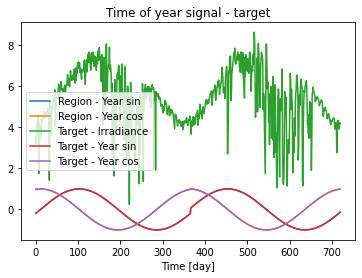

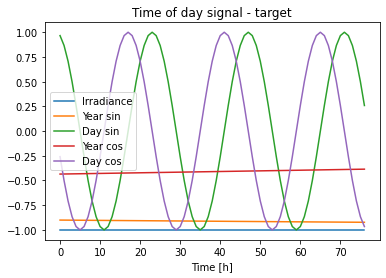

(11220, 25, 83) (1402, 25, 83)
[[-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]
 [-0.9999167 -0.0129103]]
(11220, 25, 3) (1402, 25, 3)
[[[-0.18771857  0.98222286]
  [-0.18771857  0.98222286]
  [-0.18771857  0.98222286]
  ...
  [-0.18771857  0.98222286]
  [-0.18771857  0.98222286]
  [-0.18771857  0.98222286]]

 [[-0.17082974  0.98530054]
  [-0.17082974  0.98530054]
  [-0.17082974  0.98530054]
  ...
  [-0.17082974  0.98530054]
  [-0.17082974  0.98

TypeError: ignored

In [131]:
wandb.init(entity="markub", project="solar-transformer")

def training_loop():
    # load dataset
    GLOBAL_BATCH_SIZE = 1 * strategy.num_replicas_in_sync
    train_dataset, val_dataset = load_dataset(window_size=14, batch_size=GLOBAL_BATCH_SIZE)
    print("Global BS: ", GLOBAL_BATCH_SIZE)

    with strategy.scope():
        # Generate new model
        model = Transformer(
          num_encoder_layers=1,
          num_decoder_layers=1,
          embed_dim=64,
          mlp_dim=32,
          num_heads=4,
          num_outputs=1,
          dropout_rate=0.1,
          attention_dropout_rate=0.0,
        )

    # adapt on inputs of training dataset - must be before model.compile !!!
    model.input_norm_enc.adapt(train_dataset.map(lambda x, y1, y2: x))
    print(model.input_norm_enc.variables)

    # adapt on targets of training dataset - must be before model.compile !!!
    model.input_norm_dec_1.adapt(train_dataset.map(lambda x, y1, y2: y1))
    print(model.input_norm_dec_1.variables)

    # adapt on targets of training dataset - must be before model.compile !!!
    model.input_norm_dec_2.adapt(train_dataset.map(lambda x, y1, y2: y2))
    print(model.input_norm_dec_2.variables)

    with strategy.scope():
        # Select optimizer
        optim = Adam(
            global_clipnorm=4.0,
            amsgrad=False,
        )
        #elif config.optimizer == "adamw":
        #  optim = AdamW(
        #      weight_decay=config.weight_decay,
        #      amsgrad=config.amsgrad,
        #      global_clipnorm=config.global_clipnorm,
        #      exclude_from_weight_decay=["position"]
        #  )   
        #else:
        #  raise ValueError("The used optimizer is not in list of available")
    
        model.compile(
            optimizer=optim,
            loss="log_cosh",
            metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError(), RSquare()]
        )

    # Train model
    model.fit(
        train_dataset,
        epochs=150,
        validation_data=val_dataset,
        callbacks=[
            LearningRateScheduler(cosine_schedule(base_lr=0.002, total_steps=150, warmup_steps=5)),
            PrintLR(),
            WandbCallback(monitor="val_mean_squared_error_daily", mode='min', save_weights_only=True),
            EarlyStopping(monitor="val_mean_squared_error_daily", mode='min', min_delta=0.0001, patience=8),   
        ],
        verbose=1
    )

    model.summary()

    del model
    del train_dataset
    del val_dataset

training_loop()

In [ ]:
def run(config=None):
  with wandb.init(config=config):
    config = wandb.config

    # check rules
    if (config.fc_layer_size < config.embed_layer_size):
        return

    training_loop()

In [ ]:
wandb.agent(sweep_id, run, count=32)
#wandb.agent("solar-transformer/oaii12vn", run, count=32)